In [1]:
#|export
import subprocess
import os
import time
import psutil
import struct
import numpy as np
import torch

In [2]:
#|export
def run_c(dir_path, base_command):
    # get file paths of images and their labels
    files = []
    label_count = np.zeros(10, dtype=int)
    for label in range(10):
        sd_path = os.path.join(dir_path, str(label))
        f_paths = [os.path.join(sd_path, file) for file in os.listdir(sd_path)]
        label_count[label] = len(f_paths)
        files += f_paths

    # run C inference
    command = [*base_command, *files]
    mems = []

    start_time = time.time()
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    proc = psutil.Process(process.pid)
    while process.poll() == None:
        try:
            # `proc.memory_info().rss` returns the physical memory the process has used
            mems.append(proc.memory_info().rss / 1024 / 1024) # append in megabytes
            time.sleep(0.1)  # check memory usage every 0.1 second
        except psutil.NoSuchProcess: # handle the case where the process ends abruptly
            pass
    end_time = time.time()

    output, _ = process.communicate()
    labels = np.array([label for label in range(10) for _ in range(label_count[label])])
    probs = np.fromstring(output, sep='\t').reshape(-1, 10)
    preds = np.argmax(probs, axis=1)

    acc = 100 * np.mean(preds==labels)
    dur = end_time - start_time

    return acc, dur, mems

# Python doesn't immediately release memory, so subtracting the memory usage before and 
# after execution provides an estimate of the memory consumed during the process.
def run_python(dir_path, bs):
    # get file paths of images and their labels
    files = []
    label_count = np.zeros(10, dtype=int)
    for label in range(10):
        sd_path = os.path.join(dir_path, str(label))
        f_paths = [os.path.join(sd_path, file) for file in os.listdir(sd_path)]
        label_count[label] = len(f_paths)
        files += f_paths

    # run Python inference
    sizeof_float, nch, h, w = 4, 3, 224, 224
    probs = np.empty([len(files), 10], float)
    files = [files[i:i+bs] for i in range(0, len(files), bs)] # split files into batches

    start_time = time.time()
    proc = psutil.Process(os.getpid())
    mem_before = proc.memory_info().rss
    model = torch.load("model.pt")
    for i, batch in enumerate(files):
        bs = len(batch)
        imgs = torch.empty([bs, nch, h, w])
        for j, file in enumerate(batch):
            f = open(file, "rb")
            imgs[j] = torch.tensor(struct.unpack("f"*(nch*h*w), f.read(sizeof_float*nch*h*w))).view(1,nch,h,w)
            f.close()
        out = model(imgs).detach()
        probs[i*bs:(i+1)*bs] = torch.nn.functional.softmax(out, dim=1).view(-1).numpy()
    max_mem = proc.memory_info().rss - mem_before
    end_time = time.time()

    labels = np.array([label for label in range(10) for _ in range(label_count[label])])
    probs = np.array(probs)
    preds = np.argmax(probs, axis=1)

    acc = 100 * np.mean(preds==labels)
    dur = end_time - start_time
    max_mem = max_mem / 1024 / 1024 # in megabytes

    return acc, dur, max_mem

In [3]:
path = "data/imagenette2/val_transformed_subset"

In [4]:
# rerunning decrease memory usage in notebook, Python possible use previously allocated memory
run_python(path, 1)

(100.0, 1.0591039657592773, 170.296875)

In [5]:
res = run_c(path, ["./run", "model.bin"])
res[:2]

(100.0, 19.525398015975952)

In [6]:
resq = run_c(path, ["./runq", "modelq8.bin"])
resq[:2]

(100.0, 8.612095832824707)

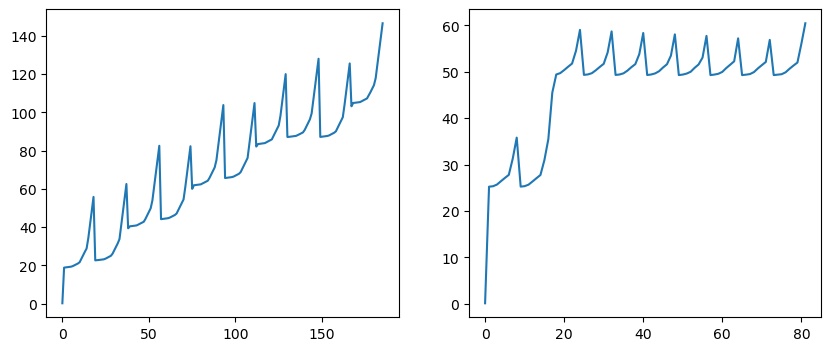

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(res[2])
ax[1].plot(resq[2])